<a href="https://colab.research.google.com/github/andrew1953/asciidoctor-fodt/blob/master/Lorentzian4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


DETAILED SCORING BREAKDOWN PER STOCK

AAPL Analysis:
------------------------------------------------------------
Predicted Return: -0.0670
Score          : -1 (×0.30 = -0.30)
------------------------------------------------------------
Confidence Interval: -0.0766 / -0.0574
Score          : -1 (×0.25 = -0.25)
------------------------------------------------------------
RSI(14)        : 30.7773
Score          : 0 (×0.20 = 0.00)
------------------------------------------------------------
Bollinger %    : -0.2992
Score          : 1 (×0.15 = 0.15)
------------------------------------------------------------
SMA Cross      : 216.5655 / 228.9642
Score          : -1 (×0.10 = -0.10)
------------------------------------------------------------
TOTAL SCORE    : -0.50
FINAL SIGNAL   : SELL

META Analysis:
------------------------------------------------------------
Predicted Return: -0.0528
Score          : -1 (×0.30 = -0.30)
------------------------------------------------------------
Confide

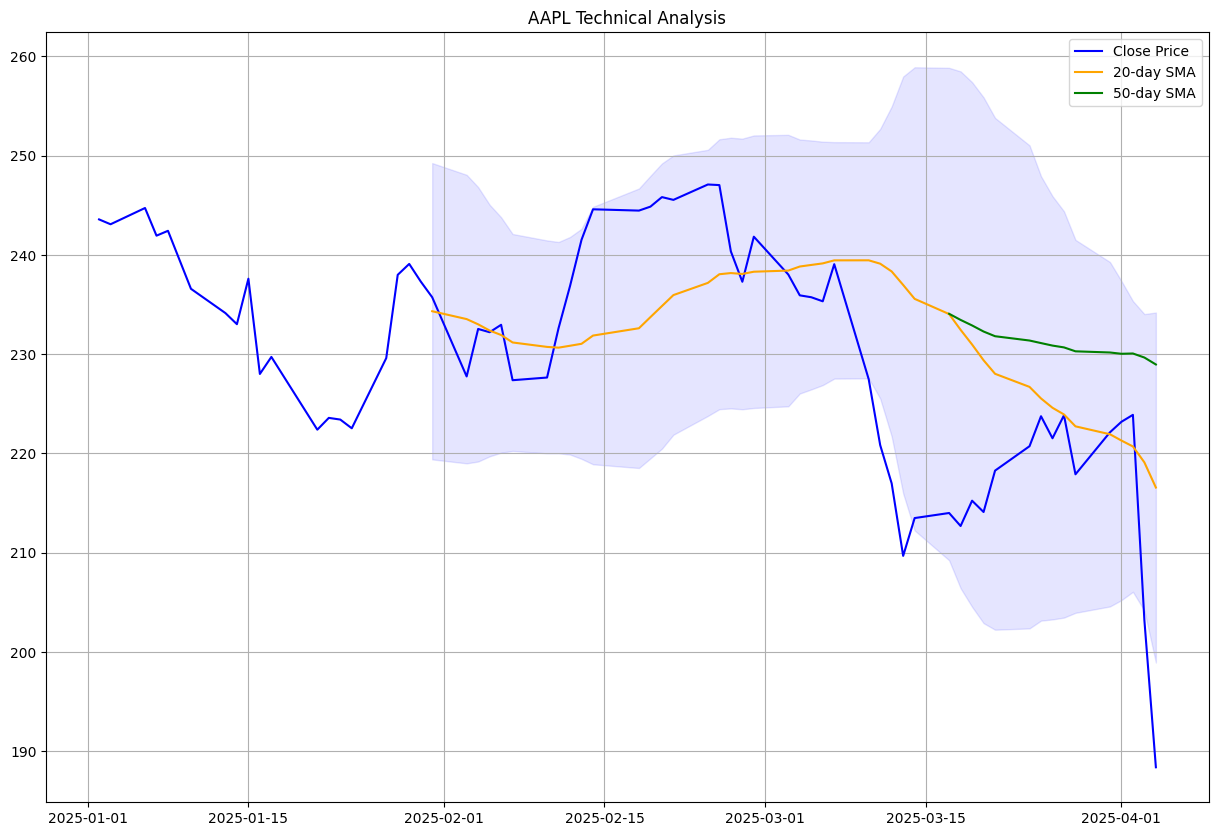

In [ ]:
# -*- coding: utf-8 -*-
"""Enhanced Stock Analysis with Detailed Scoring Output"""

!pip install seaborn -q
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

class StockAnalyzer:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.results = {}
          for i in range(len(data_returns)-1)]
            lorentzian_dis
    def get_clean_financial_data(self, ticker):
        try:
            data = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)
            data.columns = data.columns.get_level_values(0)
            data = data.ffill()
            data.index = data.index.tz_localize(None)
            return data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {str(e)}")
            return None

    @staticmethod
    def calculate_technical_indicators(data):
        data['SMA_20'] = data['Close'].rolling(window=20).mean()
        data['SMA_50'] = data['Close'].rolling(window=50).mean()
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        data['RSI'] = 100 - (100 / (1 + rs))
        data['BB_middle'] = data['Close'].rolling(window=20).mean()
        data['BB_upper'] = data['BB_middle'] + 2 * data['Close'].rolling(window=20).std()
        data['BB_lower'] = data['BB_middle'] - 2 * data['Close'].rolling(window=20).std()
        return data

    @staticmethod
    def lorentzian_distance(x, y):
        return np.log(1 + (x - y)**2)

    def calculate_volatility_metrics(self, data_returns):
        volatility = data_returns.std() * np.sqrt(252)
        skewness = stats.skew(data_returns)
        kurtosis = stats.kurtosis(data_returns)
        return {'volatility': volatility, 'skewness': skewness, 'kurtosis': kurtosis}

    def predict_next_return(self, data_returns, lorentzian_distances, threshold):
        if len(data_returns) < 2:
            return None, "Insufficient data for prediction"
        recent_distance = self.lorentzian_distance(data_returns.iloc[-2], data_returns.iloc[-1])
        if recent_distance > threshold:
            return None, "Anomaly detected. Highly volatile return expected."
        weights = np.exp(-np.arange(len(data_returns[-10:]))[::-1])
        weighted_mean = np.average(data_returns[-10:], weights=weights)
        confidence_level = 0.95
        std_err = data_returns[-30:].std() / np.sqrt(30)
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        confidence_interval = (weighted_mean - z_score * std_err, weighted_mean + z_score * std_err)
        return {
            'predicted_return': weighted_mean,
            'confidence_interval': confidence_interval,
            'message': "No anomaly detected"
        }

    def analyze_stocks(self):
        for ticker in self.tickers:
            data = self.get_clean_financial_data(ticker)
            if data is None:
                continue
            data = self.calculate_technical_indicators(data)
            data_returns = data['Close'].pct_change().dropna()
            lorentzian_distances = [self.lorentzian_distance(data_returns.iloc[i], data_returns.iloc[i+1])
                         tances = np.array(lorentzian_distances)
            threshold = lorentzian_distances.mean() + 2 * lorentzian_distances.std()
            prediction = self.predict_next_return(data_returns, lorentzian_distances, threshold)
            volatility_metrics = self.calculate_volatility_metrics(data_returns)
            self.results[ticker] = {
                'prediction': prediction,
                'volatility_metrics': volatility_metrics,
                'technical_indicators': {
                    'last_sma_20': data['SMA_20'].iloc[-1],
                    'last_sma_50': data['SMA_50'].iloc[-1],
                    'last_rsi': data['RSI'].iloc[-1],
                    'last_bb_position': (data['Close'].iloc[-1] - data['BB_lower'].iloc[-1]) /
                                      (data['BB_upper'].iloc[-1] - data['BB_lower'].iloc[-1])
                },
                'last_close': data['Close'].iloc[-1],
                'daily_std': data_returns[-30:].std()
            }

class TradingStrategy:
    def __init__(self, analyzer):
        self.analyzer = analyzer
        self.scoring_rules = {
            'predicted_return': {
                'positive': 1,
                'negative': -1,
                'weight': 0.3,
                'description': "Predicted Return"
            },
            'confidence_interval': {
                'both_positive': 1,
                'both_negative': -1,
                'mixed': 0,
                'weight': 0.25,
                'description': "Confidence Interval"
            },
            'rsi': {
                'range': (30, 70),
                'within_range': 0,
                'overbought': -1,
                'oversold': 1,
                'weight': 0.2,
                'description': "RSI(14)"
            },
            'bb_position': {
                'range': (0.2, 0.8),
                'within_range': 0,
                'above_range': -1,
                'below_range': 1,
                'weight': 0.15,
                'description': "Bollinger %"
            },
            'sma_cross': {
                'sma20_above_sma50': 1,
                'sma20_below_sma50': -1,
                'weight': 0.1,
                'description': "SMA Cross"
            }
        }
        self.decision_thresholds = {
            'buy': 0.5,
            'sell': -0.5
        }

    def calculate_scores(self, ticker_data):
        pred = ticker_data['prediction']
        tech = ticker_data['technical_indicators']
        scores = {}
        indicator_values = {}

        # Predicted Return Score
        if isinstance(pred, dict) and 'predicted_return' in pred:
            predicted_return = pred['predicted_return']
            indicator_values['predicted_return'] = predicted_return if predicted_return is not None else "N/A"
            if predicted_return is not None:
                if predicted_return > 0:
                    scores['predicted_return'] = self.scoring_rules['predicted_return']['positive']
                else:
                    scores['predicted_return'] = self.scoring_rules['predicted_return']['negative']
            else:
                scores['predicted_return'] = 0
        else:
            indicator_values['predicted_return'] = "Highly Volatile" if pred is not None else "N/A"
            scores['predicted_return'] = 0

        # Confidence Interval Score
        if isinstance(pred, dict) and 'confidence_interval' in pred:
            conf_low, conf_high = pred['confidence_interval']
            indicator_values['confidence_interval'] = (conf_low, conf_high)
            if conf_low > 0 and conf_high > 0:
                scores['confidence_interval'] = self.scoring_rules['confidence_interval']['both_positive']
            elif conf_low < 0 and conf_high < 0:
                scores['confidence_interval'] = self.scoring_rules['confidence_interval']['both_negative']
            else:
                scores['confidence_interval'] = self.scoring_rules['confidence_interval']['mixed']
        else:
            indicator_values['confidence_interval'] = "N/A"
            scores['confidence_interval'] = 0

        # RSI Score
        rsi = tech['last_rsi']
        indicator_values['rsi'] = rsi
        rsi_low, rsi_high = self.scoring_rules['rsi']['range']
        if rsi < rsi_low:
            scores['rsi'] = self.scoring_rules['rsi']['oversold']
        elif rsi > rsi_high:
            scores['rsi'] = self.scoring_rules['rsi']['overbought']
        else:
            scores['rsi'] = self.scoring_rules['rsi']['within_range']

        # BB Position Score
        bb_pos = tech['last_bb_position']
        indicator_values['bb_position'] = bb_pos
        bb_low, bb_high = self.scoring_rules['bb_position']['range']
        if bb_pos < bb_low:
            scores['bb_position'] = self.scoring_rules['bb_position']['below_range']
        elif bb_pos > bb_high:
            scores['bb_position'] = self.scoring_rules['bb_position']['above_range']
        else:
            scores['bb_position'] = self.scoring_rules['bb_position']['within_range']

        # SMA Cross Score
        sma20 = tech['last_sma_20']
        sma50 = tech['last_sma_50']
        indicator_values['sma_cross'] = (sma20, sma50)
        if sma20 > sma50:
            scores['sma_cross'] = self.scoring_rules['sma_cross']['sma20_above_sma50']
        else:
            scores['sma_cross'] = self.scoring_rules['sma_cross']['sma20_below_sma50']

        return scores, indicator_values

    def generate_signals(self):
        signals = {}
        print("\n" + "="*80)
        print("DETAILED SCORING BREAKDOWN PER STOCK")
        print("="*80)

        for ticker, analysis in self.analyzer.results.items():
            scores, indicator_values = self.calculate_scores(analysis)
            total_score = 0
            score_details = {}

            print(f"\n{ticker} Analysis:")
            print("-"*60)

            for indicator, score in scores.items():
                weight = self.scoring_rules[indicator]['weight']
                weighted_score = score * weight
                total_score += weighted_score
                score_details[indicator] = {
                    'raw_score': score,
                    'weighted_score': weighted_score
                }

                # Print indicator details with robust formatting
                desc = self.scoring_rules[indicator]['description']
                val = indicator_values[indicator]

                if indicator in ['confidence_interval', 'sma_cross']:
                    # Handle tuple values
                    if isinstance(val, tuple) and len(val) == 2:
                        if all(isinstance(x, (int, float)) for x in val):
                            print(f"{desc:15s}: {val[0]:.4f} / {val[1]:.4f}")
                        else:
                            print(f"{desc:15s}: {val[0]} / {val[1]}")
                    else:
                        print(f"{desc:15s}: {val}")
                else:
                    # Handle single values
                    if isinstance(val, (int, float)):
                        print(f"{desc:15s}: {val:.4f}")
                    else:
                        print(f"{desc:15s}: {val}")

                print(f"{'Score':15s}: {score} (×{weight:.2f} = {weighted_score:.2f})")
                print("-"*60)

            if total_score >= self.decision_thresholds['buy']:
                signal = "BUY"
            elif total_score <= self.decision_thresholds['sell']:
                signal = "SELL"
            else:
                signal = "HOLD"

            print(f"{'TOTAL SCORE':15s}: {total_score:.2f}")
            print(f"{'FINAL SIGNAL':15s}: {signal}")
            print("="*60)

            signals[ticker] = {
                'signal': signal,
                'total_score': total_score,
                'score_details': score_details,
                'indicator_values': indicator_values
            }
        return signals

def generate_report(analyzer, strategy):
    report_data = []
    signals = strategy.generate_signals()

    for ticker, analysis in analyzer.results.items():
        pred = analysis['prediction']
        vol_metrics = analysis['volatility_metrics']
        tech = analysis['technical_indicators']
        signal_data = signals[ticker]

        if isinstance(pred, dict) and 'predicted_return' in pred:
            predicted_return = pred['predicted_return']
            predicted_return = predicted_return * 100 if predicted_return is not None else "N/A"
            conf_low, conf_high = pred['confidence_interval']
            confidence_range = f"({conf_low*100:.2f}%, {conf_high*100:.2f}%)"
        else:
            predicted_return = "Highly Volatile"
            confidence_range = "N/A"

        report_data.append({
            'Stock': ticker,
            'Signal': signal_data['signal'],
            'Total Score': f"{signal_data['total_score']:.2f}",
            'Predicted Return (%)': predicted_return if isinstance(predicted_return, str) else f"{predicted_return:.2f}",
            'Confidence Interval': confidence_range,
            'Volatility (%)': f"{vol_metrics['volatility']*100:.2f}",
            'RSI': f"{tech['last_rsi']:.2f}",
            'BB Position': f"{tech['last_bb_position']:.2f}",
            'SMA 20': f"{tech['last_sma_20']:.2f}",
            'SMA 50': f"{tech['last_sma_50']:.2f}"
        })

    columns = ['Stock', 'Signal', 'Total Score', 'Predicted Return (%)',
               'Confidence Interval', 'Volatility (%)', 'RSI',
               'BB Position', 'SMA 20', 'SMA 50']
    return pd.DataFrame(report_data, columns=columns)

def plot_analysis(analyzer, ticker):
    try:
        data = analyzer.get_clean_financial_data(ticker)
        if data is None:
            return
        data = analyzer.calculate_technical_indicators(data)

        plt.figure(figsize=(15, 10))
        plt.grid(True)
        plt.plot(data.index, data['Close'], label='Close Price', color='blue')
        plt.plot(data.index, data['SMA_20'], label='20-day SMA', color='orange')
        plt.plot(data.index, data['SMA_50'], label='50-day SMA', color='green')
        plt.fill_between(data.index, data['BB_upper'], data['BB_lower'], color='blue', alpha=0.1)
        plt.title(f'{ticker} Technical Analysis')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error plotting {ticker}: {str(e)}")

def main():
    tickers = ['AAPL','META','GOOG']
    start_date = '2025-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')
    analyzer = StockAnalyzer(tickers, start_date, end_date)
    analyzer.analyze_stocks()

    strategy = TradingStrategy(analyzer)
    report = generate_report(analyzer, strategy)

    print("\nFINAL TRADING SIGNALS SUMMARY:")
    print(report[['Stock', 'Signal', 'Total Score']].to_string(index=False))

    print("\nDETAILED ANALYSIS REPORT:")
    print(report.to_string(index=False))

    plot_analysis(analyzer, tickers[0])

if __name__ == "__main__":
    main()

# New Section